Los resultados han sido guardados en 'resultados_estimaciones.txt'
2024-11-05
2024-11-06
            2024-11-04  2024-11-05  2024-11-06
2006-01-01  100.000000  100.000000  100.000000
2006-04-01  101.454170  101.454170  101.453207
2006-07-01  102.251706  102.251706  102.249684
2006-10-01  102.961061  102.961061  102.957996
2007-01-01  104.401583  104.401583  104.397539


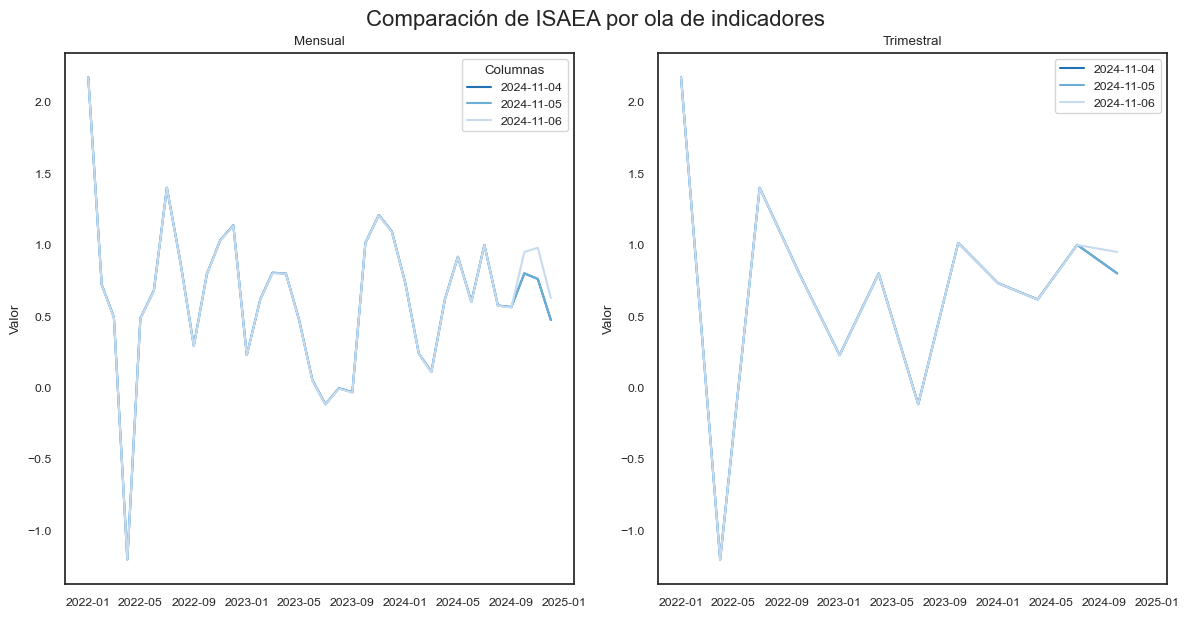

In [7]:
import os
import re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from utils import *
import io
import contextlib
import sys
from statsmodels.tsa.interp import denton as denton_module



# Directorio donde están los archivos Excel
directorio = r"C:\Users\Usuario\Documents\Github\IECA\Datos"  # Reemplaza esto con la ruta real

# Patrón para extraer la fecha del nombre del archivo
patron_fecha = r'Envío_(\d{2})_(\d{2})_(\d{4})'

nombre_hoja_mensual = 'Series_mens_vol_y_desest'  # nombre de la hoja en el archivo Excel
nombre_hoja_trimestre = 'Serie trim_vol_desest_Índice'  # nombre de la hoja en el archivo Excel

# Diccionario para almacenar los DataFrames
dfs_m = {}
dfs_q = {}

# Iterar sobre los archivos en el directorio
for archivo in os.listdir(directorio):
    if archivo.endswith('.xlsx'):  # Asumiendo que son archivos Excel
        ruta_completa = os.path.join(directorio, archivo)
        
        # Extraer la fecha del nombre del archivo
        match = re.search(patron_fecha, archivo)
        if match:
            dia, mes, anio = match.groups()
            fecha = datetime(int(anio), int(mes), int(dia)).strftime('%Y-%m-%d')
            
            # Leer el archivo Excel
            df_mens = pd.read_excel(ruta_completa, nombre_hoja_mensual)
            df_mens['fecha'] = pd.to_datetime(df_mens['fecha']).dt.strftime('%m-%y')
            # Establece la columna 'fecha' como el índice del DataFrame
            df_mens.set_index('fecha', inplace=True)
            #df_mens = df_mens.rolling(window=3).mean()
            #df_mens = df_mens[2:]

            # Guardar df_mens a CSV
            output_path = os.path.join(r"C:\Users\Usuario\Documents\Github\IECA\output", f"mens_{fecha}_jup.csv")
            df_mens.to_csv(output_path, sep=";")



            df_trims = pd.read_excel(ruta_completa, nombre_hoja_trimestre)
            df_trims['fecha'] = pd.to_datetime(df_trims['fecha']).dt.strftime('%m-%y')
            # Establece la columna 'Fecha' como el índice del DataFrame
            df_trims.set_index('fecha', inplace=True)

            #Estacionaridad de series 

            df_estacionario_mensual, diferencias_por_columna = make_all_stationary_m(df_mens)
            df_estacionario_trimestral, diferencias_por_columna = make_all_stationary_q(df_trims)

            # Guardar df_mens a CSV
            output_path = os.path.join(r"C:\Users\Usuario\Documents\Github\IECA\output", f"mens_{fecha}_est_jup.csv")
            df_estacionario_mensual.to_csv(output_path, sep=";")

            df_estacionario_mensual['Pernoctaciones - Andalucía'] = df_estacionario_mensual['Pernoctaciones - Andalucía'].diff(3)
            df_estacionario_mensual['Total afiliados SS Total - Andalucía'] = df_mens['Total afiliados SS Total - Andalucía'].diff(3)

            endog_m = df_estacionario_mensual
            endog_q = df_estacionario_trimestral*100

                        
            #Hago merge con datos mensuales "trimestralizados" y el trimestral

            # Convertir el índice del DataFrame mensual a formato de fecha y hora
            endog_m.index = pd.to_datetime(endog_m.index, format='%m-%y')
            # Convertir el índice del DataFrame mensual a formato de fecha y hora
            endog_q.index = pd.to_datetime(endog_q.index, format='%m-%y')

            endog_q.index = endog_q.index.to_period('Q')
            endog_m.index = endog_m.index.to_period('M')
         
            # Almacenar el DataFrame en el diccionario con la fecha como clave
            dfs_m[fecha] = endog_m
            dfs_q[fecha] = endog_q


dfs_m['2024-11-04'].to_csv(r"C:\Users\Usuario\Documents\Github\IECA\output\mensjup.csv", sep=";")
dfs_q['2024-11-04'].to_csv(r"C:\Users\Usuario\Documents\Github\IECA\output\trijup.csv", sep=";")     

ficheros = list(dfs_m.keys())
ficheros.sort(key=lambda x: datetime.strptime(x, '%Y-%m-%d'))
dfs_m = {fecha: dfs_m[fecha] for fecha in ficheros}


mejores_regresores_m = ['Consumo aparente de cemento - Andalucía', 
                        'Total afiliados SS Total - Andalucía',
                        'Matriculación de turismos - Andalucía'
                        ]

mejores_regresores_q = ['Ocupados EPA  total - Andalucía', 
                        'Índice de producción agrícola - Andalucía',
                        'pib'
                        ]

endog_m_c = dfs_m[ficheros[0]][mejores_regresores_m]
endog_q=dfs_q[ficheros[0]][mejores_regresores_q]

# Crear y ajustar el modelo DFMQ
mod = sm.tsa.DynamicFactorMQ(endog_m_c, 
                            endog_quarterly=endog_q, 
                            factor_orders = 2, 
                            factors=1,
                            factor_multiplicities=None)
res = mod.fit(maxiter=2000)

# Tu código para crear y ajustar el modelo


# Abrir un archivo de texto para escribir
with open(r"C:\Users\Usuario\Documents\Github\IECA\output\resultados_estimaciones.txt", 'w') as f:
    # Escribir una cabecera
    f.write("Resultados de las estimaciones\n")
    f.write("=============================\n\n")

    
    f.write("Estimación del modelo DFMQ\n\n")
    f.write("=============================\n\n")

    # Capturar el output del summary() en una variable
    old_stdout = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout

    print(res.summary())

    sys.stdout = old_stdout
    summary_output = new_stdout.getvalue()

    # Escribir el summary en el archivo
    f.write(summary_output)

    # Puedes añadir más información si lo deseas
    f.write("\nInformación adicional:\n")
    f.write(f"AIC: {res.aic}\n")
    f.write(f"BIC: {res.bic}\n")


    # Añadir información adicional
    f.write("\nInformación adicional:\n")
    f.write(f"AIC: {res.aic}\n")
    f.write(f"BIC: {res.bic}\n")

    # Añadir los coeficientes de determinación
    f.write("\nCoeficientes de determinación (R^2):\n")
    
    f.write("===================================\n\n")
    rsquared = res.get_coefficients_of_determination(method='individual')
    
    top_ten = []
    for factor_name in rsquared.columns[:6]:
        top_factor = (rsquared[factor_name].sort_values(ascending=False)
                                           .iloc[:30].round(2).reset_index())
        top_factor.columns = ['Variable', 'R^2']
        
        # Guardar para el DataFrame combinado
        top_factor.columns = pd.MultiIndex.from_product([
            [f'Top ten variables explained by {factor_name}'],
            ['Variable', r'$R^2$']])
        top_ten.append(top_factor)

    # Crear y escribir el DataFrame combinado
    f.write("\nTabla combinada de top variables XXXX por factor:\n")
    combined_df = pd.concat(top_ten, axis=1)
    f.write(combined_df.to_string())

print("Los resultados han sido guardados en 'resultados_estimaciones.txt'")


# Archivo vintages
vintage_results = {ficheros[0]: res}  #aquí la fecha de inicio

start = '2000'

# Apply our results to the remaining vintages
for vintage in ficheros[1:]:
    print(vintage)

    # Get updated data for the vintage
    updated_endog_m = dfs_m[vintage][mejores_regresores_m].loc[start:, :]
    updated_endog_q = dfs_q[vintage][mejores_regresores_q].loc[start:, :]

    # Get updated results for for the vintage
    vintage_results[vintage] = res.apply(
        updated_endog_m, endog_quarterly=updated_endog_q, retain_standardization=False)
    
# Create forecasts results objects, through the end of 20201
prediction_results = res.get_prediction(start='2006-01', end='2024-12')

variables = ['pib']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]
predictionGDP= point_predictions.resample('Q').last()

#Predicción mejores regresores

point_predictions_mejores = prediction_results.predicted_mean[mejores_regresores_m + mejores_regresores_q]	


# Compute forecasts for each vintage
forecasts_m = {vintage: res.get_prediction(start='2006-01', end='2024-12').predicted_mean['pib']
             for vintage, res in vintage_results.items()}

forecast_mensuales = pd.DataFrame(forecasts_m)

# Compute forecasts for each vintage
forecasts_q = {vintage: res.get_prediction(start='2006-01', end='2024-12').predicted_mean['pib']
                         .resample('Q').first()
             for vintage, res in vintage_results.items()}

forecast_trimestrales = pd.DataFrame(forecasts_q)

# Primero, convierte el índice de períodos a timestamps
forecast_mensuales.index = forecast_mensuales.index.to_timestamp()

# Luego, si es necesario, convierte a datetime
forecast_mensuales.index = pd.to_datetime(forecast_mensuales.index)


# Primero, convierte el índice de períodos a timestamps
forecast_trimestrales.index = forecast_trimestrales.index.to_timestamp()

# Luego, si es necesario, convierte a datetime
forecast_trimestrales.index = pd.to_datetime(forecast_trimestrales.index)

#Índice trimestrales
# Asumimos que forecast_trimestrales ya está cargado y contiene las tasas de crecimiento


# Crear un nuevo dataframe para los índices
#----------------------------------------------------------------------
indices_trimestrales = pd.DataFrame(index=forecast_trimestrales.index)

# Para cada columna en forecast_trimestrales
for columna in forecast_trimestrales.columns:
    # Inicializar la serie con 100 para el primer trimestre
    serie_indice = pd.Series(index=forecast_trimestrales.index, dtype=float)
    serie_indice.iloc[0] = 100
    
    # Calcular los valores del índice para los trimestres siguientes
    for i in range(1, len(serie_indice)):
        tasa_crecimiento = forecast_trimestrales[columna].iloc[i]
        serie_indice.iloc[i] = serie_indice.iloc[i-1] * (1 + tasa_crecimiento/100)
    
    # Añadir la nueva serie al dataframe de índices
    indices_trimestrales[columna] = serie_indice

# Mostrar las primeras filas del nuevo dataframe
print(indices_trimestrales.head())

# Si quieres, puedes guardar este nuevo dataframe en un archivo CSV
indices_trimestrales.to_csv(r"C:\Users\Usuario\Documents\Github\IECA\output\indices_trimestrales.csv", sep=";")


#Mensualizar indices trimestrales
#----------------------------------------------------------------------

#De la serie mensual obtengo la media movil

# Supongamos que forecast_mensuales es tu DataFrame original
# Calcular la media móvil de tres meses
df_mens_moving_average = forecast_mensuales.rolling(window=3, min_periods=1).mean()
df_mensualizada = 100*((1 + df_mens_moving_average/100) ** (1/3)-1)

# Crear un nuevo DataFrame con el mismo índice y columnas que df_transformed
df_growth_based = pd.DataFrame(index=df_mensualizada.index, columns=df_mensualizada.columns)

# Inicializar la primera fila con 100
df_growth_based.iloc[0] = 100

# Iterar sobre las filas y aplicar la fórmula de crecimiento
for i in range(1, len(df_mensualizada)):
    df_growth_based.iloc[i] = df_growth_based.iloc[i-1] * (1 + df_mensualizada.iloc[i]/100)

# Convertir a float y manejar posibles valores no numéricos
def safe_convert_to_float(arr):
    # Primero, convertimos a pandas Series para manejar mejor los NaN
    series = pd.Series(arr)
    # Convertimos a numeric, coercionando errores a NaN
    numeric_series = pd.to_numeric(series, errors='coerce')
    # Eliminamos los NaN
    cleaned_series = numeric_series.dropna()
    # Convertimos de vuelta a numpy array
    return cleaned_series.to_numpy()


# Crear un DataFrame vacío para almacenar los resultados
resultados_mensuales = pd.DataFrame(index=df_growth_based.index)

# Iterar sobre todas las columnas de df_growth_based
for columna in df_growth_based.columns:
    X_mensual = df_growth_based[columna].to_numpy()
    
    # Verificar si la columna existe en indices_trimestrales
    if columna in indices_trimestrales.columns:
        y_trimestral = indices_trimestrales[columna].to_numpy()
    else:
        print(f"La columna {columna} no está en indices_trimestrales. Se omite.")
        continue

    X_mensual_clean = safe_convert_to_float(X_mensual)
    y_trimestral_clean = safe_convert_to_float(y_trimestral)

    z_mensual = denton_method(y_trimestral_clean, X_mensual_clean) * 3
    z_mensual = pd.Series(z_mensual, index=df_growth_based.index)

    # Añadir la serie mensualizada al DataFrame de resultados
    resultados_mensuales[columna] = z_mensual

# Guardar los resultados en un archivo CSV
resultados_mensuales.to_csv(r"C:\Users\Usuario\Documents\Github\IECA\output\indices_mensuales.csv", sep=";")

#Figura 
#----------------------------------------------------------------------

# Configurar el estilo de Seaborn y quitar el grid

# Filtrar el DataFrame para mostrar solo desde enero de 2020 en adelante
forecast_mensuales_f = forecast_mensuales.loc['2022-01':]
forecast_trimestrales_f = forecast_trimestrales.loc['2022-01':]

# Crear una paleta de colores en degradado de más claro a más oscuro
n_columns_mensual = forecast_mensuales_f.shape[1]
palette_mensual = sns.color_palette("Blues_r", n_colors=n_columns_mensual)

n_columns_trimestral = forecast_trimestrales_f.shape[1]
palette_trimestral = sns.color_palette("Blues_r", n_colors=n_columns_trimestral)

# Configurar el estilo de Seaborn y quitar el grid
sns.set(style="white")
sns.set_context("talk")
sns.set_context("notebook", font_scale=0.8)  # Ajustar el tamaño del texto aquí

# Crear una figura y ejes con subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# Dibujar cada columna con el color correspondiente en el primer subplot
for i, col in enumerate(forecast_mensuales_f.columns):
    sns.lineplot(data=forecast_mensuales_f, x=forecast_mensuales_f.index, y=col, color=palette_mensual[i], label=col, ax=ax1)

# Configurar el título y las etiquetas de los ejes para el primer subplot
ax1.set_title('Mensual')
ax1.set_ylabel('Valor')
ax1.legend(title='Columnas')

# Dibujar cada columna con el color correspondiente en el segundo subplot
for i, col in enumerate(forecast_trimestrales_f.columns):
    sns.lineplot(data=forecast_trimestrales_f, x=forecast_trimestrales_f.index, y=col, color=palette_trimestral[i], label=col, ax=ax2)

# Configurar el título y las etiquetas de los ejes para el segundo subplot
ax2.set_title('Trimestral')
ax2.set_ylabel('Valor')

# Ajustar el espacio entre los subplots
plt.tight_layout()


# Agregar un título general al conjunto de gráficos
plt.suptitle('Comparación de ISAEA por ola de indicadores', fontsize=16, y=1.02)

# Mostrar la figura
plt.show()

forecast_mensuales.to_csv(r"C:\Users\Usuario\Documents\Github\IECA\output\indicador_mensual.csv", sep=";")
forecast_trimestrales.to_csv(r"C:\Users\Usuario\Documents\Github\IECA\output\indicador_trimestral.csv", sep=";")

news_results = {}

impact_date = '2024-12'

for i in range(1, len(ficheros)):
    vintage = ficheros[i]
    prev_vintage = ficheros[i - 1]

    news_results[vintage] = vintage_results[vintage].news(
        vintage_results[prev_vintage],
        impact_date=impact_date,
        impacted_variable='pib',
        comparison_type='previous')
    
# Guardar cada Summary en un archivo txt
for name, result in news_results.items():
    output_file = os.path.join(r"C:\Users\Usuario\Documents\Github\IECA\output\Nowcasting", f'summary_{name}.txt')
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(result.summary().as_text())

In [35]:

news_results= vintage_results['2024-11-06'].news(
        vintage_results['2024-11-04'],
        impact_date=impact_date,
        impacted_variable='pib',
        comparison_type='previous')

In [36]:
news_results.details_by_impact

observed  \
impact date impacted variable update date updated variable                                            
2024-12     pib               2024-08     Cifra negocios del sector servicios - Andalucía -0.005514   
                                          Índice ventas grandes superficies - Andalucía   -0.021833   
                              2024-09     Consumo aparente de cemento - Andalucía          0.038522   
                                          Índice ventas grandes superficies - Andalucía    0.006460   

                                                                                           forecast (prev)  \
impact date impacted variable update date updated variable                                                   
2024-12     pib               2024-08     Cifra negocios del sector servicios - Andalucía        -0.003986   
                                          Índice ventas grandes superficies - Andalucía          -0.022647   
                              2024-09     Consumo aparente de cemento - Andalucía                 0.029022   
                                          Índice ventas grandes superficies - Andalucía          -0.015293   

                                                                                               news  \
impact date impacted variable update date updated variable                                            
2024-12     pib               2024-08     Cifra negocios del sector servicios - Andalucía -0.001527   
                                          Índice ventas grandes superficies - Andalucía    0.000814   
                              2024-09     Consumo aparente de cemento - Andalucía          0.009500   
                                          Índice ventas grandes superficies - Andalucía    0.021753   

                                                                                              weight  \
impact date impacted variable update date updated variable                                             
2024-12     pib               2024-08     Cifra negocios del sector servicios - Andalucía   9.424794   
                                          Índice ventas grandes superficies - Andalucía    -7.683970   
                              2024-09     Consumo aparente de cemento - Andalucía           3.528469   
                                          Índice ventas grandes superficies - Andalucía    23.347635   

                                                                                             impact  
impact date impacted variable update date updated variable                                           
2024-12     pib               2024-08     Cifra negocios del sector servicios - Andalucía -0.014393  
                                          Índice ventas grandes superficies - Andalucía   -0.006255  
                              2024-09     Consumo aparente de cemento - Andalucía          0.033521  
                                          Índice ventas grandes superficies - Andalucía    0.507879

In [ ]:
df_mens

In [49]:
df_mens.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295 entries, 03-00 to 09-24
Data columns (total 13 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   Consumo aparente de cemento - Andalucía                                       295 non-null    float64
 1   Consumo de gasolina y gasóleo                                                 294 non-null    float64
 2   Exportaciones de bienes - Andalucía                                           294 non-null    float64
 3   Importaciones de bienes - Andalucía                                           294 non-null    float64
 4   IPIAN Div 23                                                                  294 non-null    float64
 5   Índice general de producción industrial - Andalucía                           295 non-null    float64
 6   ICMA General sin estaciones de se

In [ ]:
# Añadir opción para seleccionar el final del periodo de predicción
                    st.sidebar.markdown("---")
                    st.sidebar.header("Configuración de Predicción")
                    end_date = st.sidebar.date_input(
                        "Fecha final de predicción",
                        value=datetime(2024, 12, 31),
                        min_value=datetime(2000, 1, 1),
                        max_value=datetime(2030, 12, 31),
                        help="Selecciona la fecha final para las predicciones"
                    ).strftime('%Y-%m')

                    variables = ['pib']
                    
                    # Create forecasts results objects
                    prediction_results = res.get_prediction(start='2006-01', end=end_date)